In [2]:
#Import the libraries for the project
import numpy as np
import pandas  as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

#Load the dataset
df=pd.read_csv(r'E-MTAB-2770-query-results.tpms.tsv',
             sep="\t", comment='#')

df


,Gene ID,Gene Name,"22Rv1, prostate carcinoma","23132/87, gastric adenocarcinoma","253J, bladder carcinoma","253J-BV, bladder carcinoma","42-MG-BA, glioblastoma","5637, bladder carcinoma","59M, high grade ovarian serous adenocarcinoma","639-V, ureter urothelial carcinoma",...,"WSU-DLCL2, diffuse large B-cell lymphoma","YAPC, pancreatic carcinoma","YD-10B, tongue squamous cell carcinoma","YD-15, tongue squamous cell carcinoma","YD-38, head and neck squamous cell carcinoma","YD-8, tongue squamous cell carcinoma","YH-13, glioblastoma","YKG1, glioblastoma","ZR-75-1, invasive ductal carcinoma","ZR-75-30, invasive ductal carcinoma"
0,ENSG00000000003,TSPAN6,7.0,10.0,29.0,33.0,33.0,86.0,23.0,45.0,...,0.7,71.0,15.0,31.0,30.0,60.0,39.0,84.0,14.0,23.0
1,ENSG00000000005,TNMD,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000000419,DPM1,151.0,238.0,94.0,132.0,223.0,222.0,182.0,286.0,...,113.0,239.0,171.0,206.0,208.0,252.0,136.0,235.0,374.0,120.0
3,ENSG00000000457,SCYL3,17.0,27.0,5.0,5.0,5.0,6.0,4.0,5.0,...,11.0,11.0,5.0,5.0,6.0,8.0,10.0,11.0,32.0,21.0
4,ENSG00000000460,C1orf112,24.0,12.0,4.0,9.0,9.0,27.0,9.0,11.0,...,19.0,11.0,7.0,13.0,23.0,8.0,12.0,15.0,20.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3318,ENSG00000106537,TSPAN13,176.0,401.0,32.0,16.0,21.0,153.0,49.0,4.0,...,137.0,274.0,11.0,53.0,59.0,5.0,25.0,392.0,925.0,694.0
3319,ENSG00000106538,RARRES2,7.0,0.2,2.0,2.0,NaN,0.6,12.0,4.0,...,0.8,10.0,0.4,0.5,0.2,1.0,1.0,0.9,3.0,0.3
3320,ENSG00000106541,AGR2,20.0,2057.0,0.4,0.4,0.4,2.0,0.6,0.3,...,3.0,1445.0,1.0,12.0,3.0,0.4,1.0,22.0,2541.0,1034.0
3321,ENSG00000106546,AHR,6.0,85.0,11.0,4.0,47.0,17.0,14.0,0.1,...,8.0,48.0,12.0,5.0,21.0,61.0,88.0,53.0,18.0,17.0


In [3]:
#Define the targets for prediction (cancer samples)
target=list(df.columns[2:])

#A function to engineer the labels  list
# The 2 labels of interest are 'leukemia' and 'other cancers'
def eng_labels(x):
   labs=[]
   for s in x:
         if 'leukemia' in s:
             labs.append('leukemia')
         else: 
             labs.append('other cancers')
   return(labs)

#Engineer the labels
labs=eng_labels(target)
labs=['Gene']+labs
labs=pd.Series(labs)

In [6]:
#Engineer the data
data=df.iloc[:,1:]   
data.columns=labs
data=data.transpose()
data.columns=data.loc['Gene',:]
data=data.iloc[1:,:]
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 20)
data.head(20)

Gene,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,MEST,MEOX2,ANKMY2,ACTR3C,POU6F2,TSPAN13,RARRES2,AGR2,AHR,CHCHD3
other cancers,7.0,NaN,151.0,17.0,24.0,NaN,0.1,100.0,124.0,95.0,...,95.0,NaN,17.0,2.0,4.0,176.0,7.0,20.0,6.0,106.0
other cancers,10.0,NaN,238.0,27.0,12.0,NaN,0.4,325.0,101.0,48.0,...,39.0,NaN,34.0,0.4,NaN,401.0,0.2,2057.0,85.0,76.0
other cancers,29.0,0.1,94.0,5.0,4.0,NaN,0.3,76.0,16.0,17.0,...,8.0,NaN,47.0,0.4,NaN,32.0,2.0,0.4,11.0,66.0
other cancers,33.0,NaN,132.0,5.0,9.0,NaN,0.1,60.0,20.0,35.0,...,11.0,0.1,34.0,2.0,NaN,16.0,2.0,0.4,4.0,122.0
other cancers,33.0,NaN,223.0,5.0,9.0,NaN,0.4,99.0,8.0,42.0,...,131.0,10.0,100.0,NaN,NaN,21.0,NaN,0.4,47.0,47.0
other cancers,86.0,NaN,222.0,6.0,27.0,0.3,2.0,138.0,11.0,43.0,...,9.0,0.6,23.0,0.9,NaN,153.0,0.6,2.0,17.0,138.0
other cancers,23.0,NaN,182.0,4.0,9.0,NaN,9.0,123.0,38.0,47.0,...,242.0,0.1,28.0,2.0,0.6,49.0,12.0,0.6,14.0,92.0
other cancers,45.0,NaN,286.0,5.0,11.0,NaN,15.0,151.0,23.0,75.0,...,647.0,0.1,32.0,0.5,NaN,4.0,4.0,0.3,0.1,127.0
other cancers,85.0,NaN,195.0,4.0,14.0,NaN,0.3,109.0,20.0,51.0,...,3.0,NaN,32.0,4.0,NaN,382.0,0.7,0.8,6.0,79.0
leukemia,0.2,NaN,101.0,11.0,22.0,0.1,0.2,0.4,19.0,102.0,...,0.3,NaN,33.0,NaN,NaN,104.0,0.1,0.5,NaN,135.0


# New Section

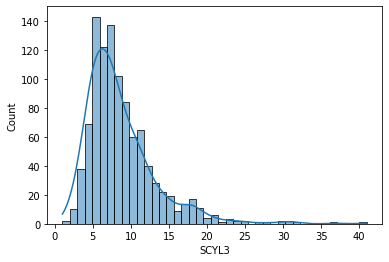

In [7]:

#Visualize SCYL3 gene expression across the sample
sns.histplot(data['SCYL3'], kde=True) 


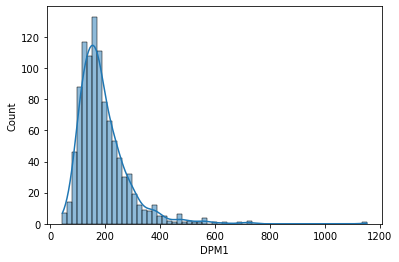

In [8]:
sns.histplot(data['DPM1'], kde=True) 

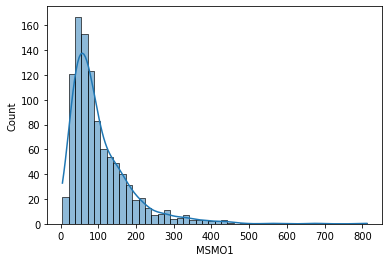

In [9]:
sns.histplot(data['MSMO1'], kde=True) 

In [10]:



#Data preprocessing
data_x=data                       
data_x=np.array(data_x)
le = LabelEncoder()
le.fit(data.index)
data_y=le.transform(data.index) 
data_y=pd.Series(data_y)


In [11]:
#Train/Test split
xtrain, xtest, ytrain, ytest = train_test_split(
 data_x, data_y, test_size=0.33, random_state=5)

#Converting the data to np.arrays
#This is needed to facilitate the training process
xtrain=np.array(xtrain, dtype=np.float32)
ytrain=np.array(ytrain, dtype=np.float32)


xtrain, ytrain=shuffle(xtrain, ytrain)
xtest, ytest=shuffle(xtest, ytest)

In [12]:
#These are the parameters to use for tuning the training process
p={ 'boosting':'dart', 'learning_rate':0.01, 'objective':'binary', 'max_depth':6
   , 'num_leaves':102, 'min_data_in_leaf':40, 'bagging_fraction':1,'device_type':'cpu',
   'feature_fraction':1, 'verbose':0, 'bagging_freq':7, 'extra_trees':'true','cegb_tradeoff':5,
  'max_bin':100, 'min_data_in_bin':6,'n_estimators':15750}

In [13]:
#Train the classifier and name is lgbmodel
lgbmodel=LGBMClassifier(**p).fit(xtrain, ytrain)

In [14]:

#Make predictions and calculate accuracy
predictions = lgbmodel.predict(xtest)
rpreds = [round(i) for i in predictions]
accuracy = accuracy_score(ytest, rpreds)
accuracy

0.9792284866468842

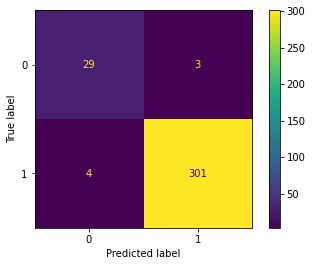

In [15]:
#Make the confusion matrix
cm = confusion_matrix(ytest, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [16]:
#Extract the feature importances
importances=lgbmodel.feature_importances_
importances=pd.Series(importances)
importances.index=data.columns
importances= importances.sort_values(ascending=False)
importances[0:29].to_csv(r'important_genes.csv', sep='\t', header='true')

<BarContainer object of 29 artists>

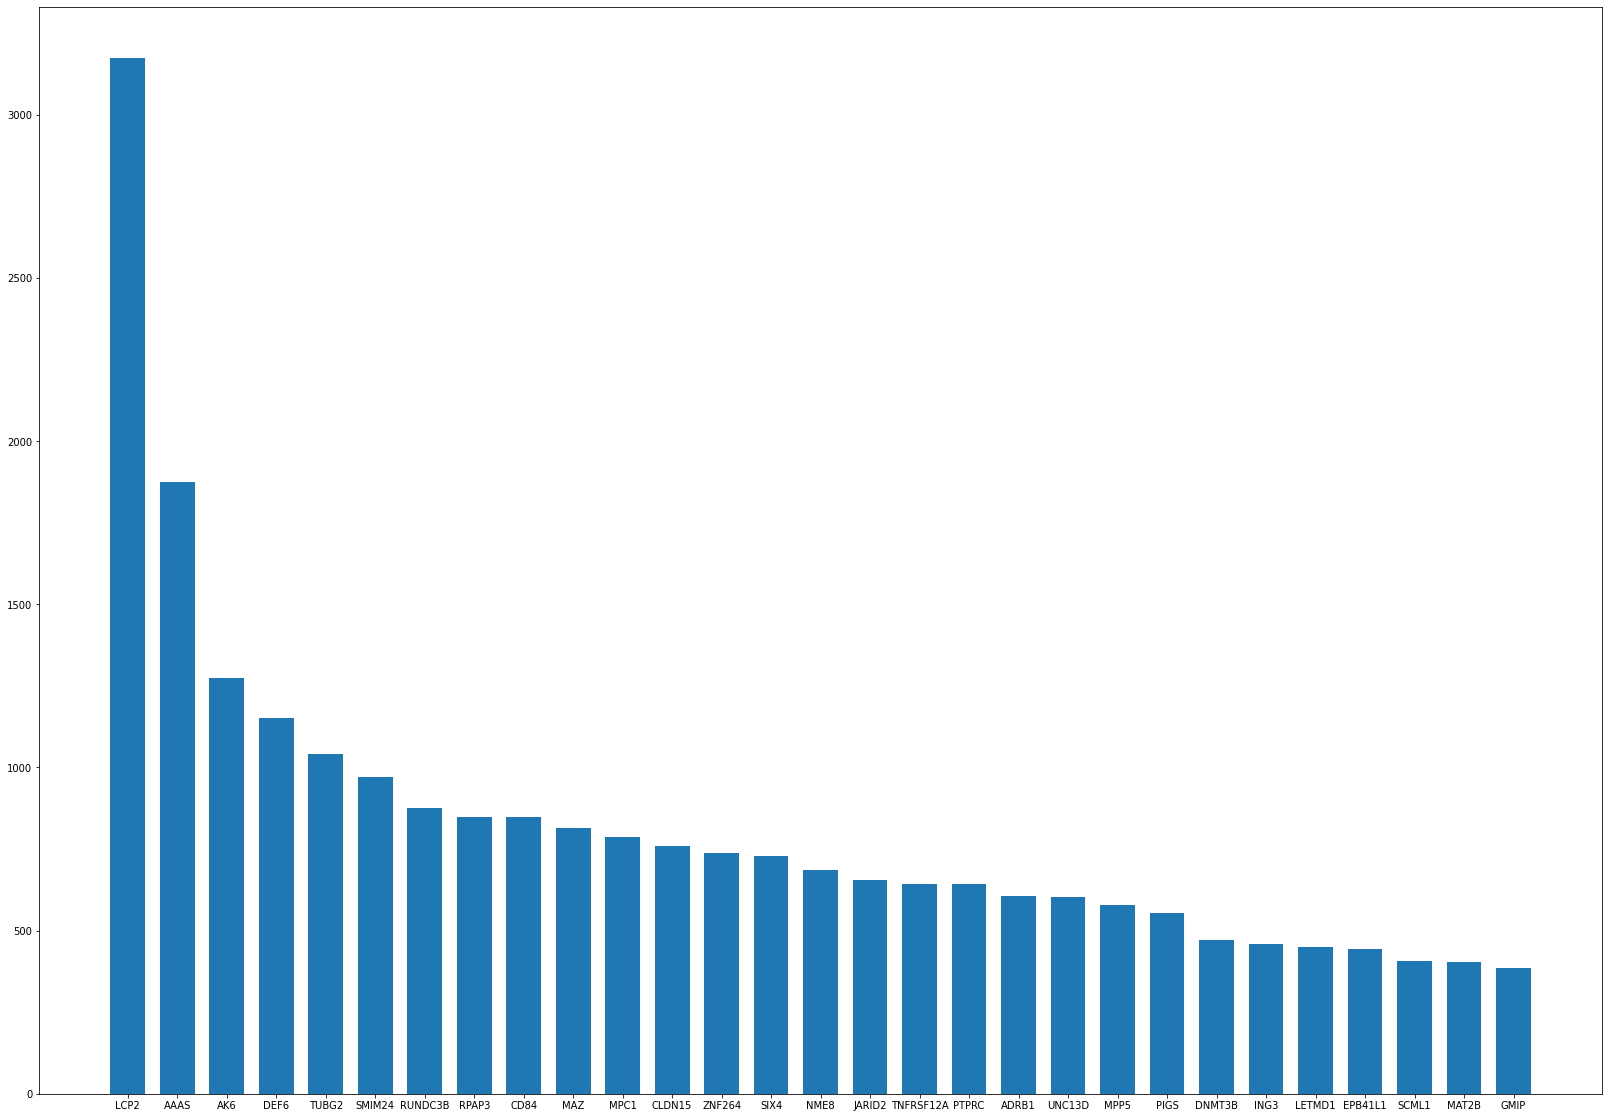

In [17]:

#Data visualization of the feature importances
plt.figure(figsize=(28,20))
plt.bar(importances[0:29].index, importances[0:29], width=0.7, bottom=None, align='center', data=None)
